In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

import string
import unicodedata

import json
import nltk
from collections import Counter

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# read in full df
reviews_df = pd.read_pickle("./data/final_reviews.pkl")

In [11]:
reviews_df

,text,funny or not
0,Apparently Prides Osteria had a rough summer a...,0
1,This store is pretty good. Not as great as Wal...,0
2,I called WVM on the recommendation of a couple...,0
3,I've stayed at many Marriott and Renaissance M...,0
4,The food is always great here. The service fro...,0
...,...,...
8635398,"In December, I called in (as a returning custo...",0
8635399,This guy is a moron that will stalk and harass...,0
8635400,"Yummy, great chew on the bagel\nFriendly staff...",1
8635401,This used to be my car wash of choice. They di...,0


### Text Pre-processing

In [12]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/{}\[\]\|@]')

BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [13]:
## function for cleaning text

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    # text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('\n', '')
    # text = re.sub(r'\W+', '', text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

In [14]:
reviews_df.text = reviews_df.text.apply(clean_text)

In [20]:
reviews_df.text.iloc[15]

"Quickly stopped in for a UFC fight. I sat down at the bar while my boyfriend parked the car. Although the restaurant bar was packed and LOUD, the bartender  (Vanessa) came over within a minute. Prompt service with a smile. When my boyfriend arrived a few minutes later, we didn't see Vanessa behind the bar so we tried to flag down her male coworker. He was caught up watching the fight and it took a few minutes to get his attention - which is fine. Not fine, however, is that after I ordered a beer, he stood and texted for a few minutes before getting my beer and held his arm up to shield his texting from management lol. Vanessa, however, is an excellent bartender!! As loud as it is in this place, she continually scanned the bar looking for people attempting to make eye contact with her for service. I watched her work (my boyfriend and I have thirty years of food and beverage experience between the two of us) and she was focused and productive, but most importantly, she was ATTENTIVE! Gi

### Tokenization ##

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(reviews_df.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1218613 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(reviews_df.text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8635403, 200)


In [23]:
y = reviews_df['funny or not'].values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (8635403,)


In [24]:
# train test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6908322, 200) (6908322,)
(1727081, 200) (1727081,)


In [26]:
# balance train data
X_train_funny = pd.DataFrame(X_train[y_train == 1])
X_train_not_funny = pd.DataFrame(X_train[y_train == 0]).sample(n=len(X_train_funny), random_state=42)

y_train_funny = pd.DataFrame(y_train[y_train == 1])
y_train_not_funny = pd.DataFrame(y_train[y_train == 0]).sample(n=len(y_train_funny), random_state=42)

X_train_balanced = pd.concat([X_train_funny, X_train_not_funny])
y_train_balanced = pd.concat([y_train_funny, y_train_not_funny])

In [27]:
# # save to csv
# X_train_balanced.to_csv('X_train_balanced_tokenized_10000_200.csv')
# y_train_balanced.to_csv('y_train_balanced_tokenized_10000_200.csv')

In [9]:
# # read in csvs
# X_train_balanced = pd.read_csv('X_train_balanced_tokenized_10000_200.csv')
# y_train_balanced = pd.read_csv('y_train_balanced_tokenized_10000_200.csv')

In [11]:
# drop unnamed column
X_train_balanced = X_train_balanced.drop(['Unnamed: 0'], axis = 1)
y_train_balanced = y_train_balanced.drop(['Unnamed: 0'], axis = 1)

In [28]:
X_train_balanced

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,62,132,62,1077,5,289,8,11,3,298,...,8302,206,5541,5,32,40,197,27,1,6160
1,37,17,18,73,23,5,587,1,864,7,...,2445,279,52,1805,1,1717,2,5,4,747
2,207,10,128,432,43,145,6,66,231,94,...,17,41,3,6,5137,600,24,1802,20,32
3,45,4,47,347,1127,254,30,10,3212,1713,...,49,68,2075,2,213,100,290,893,20,8
4,0,0,0,0,0,0,0,0,0,0,...,12,158,11,381,94,382,159,1192,2,1039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499243,0,0,0,0,0,0,0,0,0,0,...,92,9,35,84,83,35,206,5687,9,216
4685699,0,0,0,0,0,0,0,0,0,0,...,983,10,690,1697,1381,281,56,38,125,1876
3177944,0,0,0,0,0,0,0,0,0,0,...,766,9,34,47,7,1,30,7729,676,1177
4955577,7,12,302,146,61,822,931,171,1987,1,...,106,3,1318,19,22,1,319,9,13,485


In [30]:
# shuffle data 
X_train_balanced = X_train_balanced.sample(frac=1, random_state=42)
y_train_balanced = y_train_balanced.sample(frac=1, random_state=42)

In [ ]:
# take sample of 50k/100k

sample_X_train_balanced = X_train_balanced.sample(n=50000, random_state=42)
sample_y_train_balanced = y_train_balanced.sample(n=50000, random_state=42)

In [40]:
sample_X_train_balanced

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
82335,47,50,19,8781,584,128,1425,712,14,68,...,186,7,308,42,29,553,5,29,5132,2310
3353430,0,0,0,0,0,0,0,0,0,0,...,11,38,1,46,9,1151,113,245,37,6586
186759,11,647,259,2156,8647,52,3372,8647,17,39,...,223,4088,3,765,541,157,406,449,739,1365
114189,128,28,457,3002,139,66,12,690,47,591,...,16,31,87,73,4,507,7,43,246,135
246001,265,1,19,45,35,102,43,9405,11,543,...,541,79,80,8,79,80,8,79,80,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388614,0,0,0,0,0,0,0,0,0,0,...,572,194,1146,519,2,3674,1145,16,9,900
47838,340,135,917,521,3,245,37,1,20,1,...,37,21,4,6062,124,3,64,596,5,19
5448639,0,0,0,0,0,0,0,0,0,0,...,199,3,147,1752,63,334,278,253,40,190
50071,129,16,31,688,14,823,3,765,56,6076,...,1215,16,9,113,22,68,1011,741,1533,144


In [51]:
y_train_balanced.value_counts()

0    272931
1    272931
dtype: int64

In [ ]:
# shuffle test data

X_test = pd.DataFrame(X_test).sample(frac=1, random_state=42)
y_test = pd.DataFrame(y_test).sample(frac=1, random_state=42)

### Modeling

#### LSTM with one layer

In [113]:
EMBEDDING_DIM = 100
LSTM_OUT = 100

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 200, 100)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
# train the model on sample of 50k

history = model.fit(sample_X_train_balanced, sample_y_train_balanced, 
                    #epochs=3, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
625/625 [==============================] - 131s 199ms/step - loss: 0.6554 - accuracy: 0.5984 - precision: 0.6043 - recall: 0.5653 - val_loss: 0.5725 - val_accuracy: 0.7104 - val_precision: 0.6901 - val_recall: 0.7625
Epoch 2/3
625/625 [==============================] - 121s 193ms/step - loss: 0.5622 - accuracy: 0.7196 - precision: 0.7266 - recall: 0.7052 - val_loss: 0.5483 - val_accuracy: 0.7269 - val_precision: 0.7457 - val_recall: 0.6876
Epoch 3/3
625/625 [==============================] - 121s 194ms/step - loss: 0.5336 - accuracy: 0.7441 - precision: 0.7551 - recall: 0.7131 - val_loss: 0.5466 - val_accuracy: 0.7280 - val_precision: 0.7703 - val_recall: 0.6488


In [ ]:
from 

In [46]:
# make sure to reinstantiate model then train on full data

history = model.fit(X_train_balanced, y_train_balanced, 
                    #epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
6824/6824 [==============================] - 2013s 294ms/step - loss: 0.5743 - accuracy: 0.6976 - precision: 0.6932 - recall: 0.7209 - val_loss: 0.5202 - val_accuracy: 0.7444 - val_precision: 0.7435 - val_recall: 0.7466
Epoch 2/5
6824/6824 [==============================] - 1790s 262ms/step - loss: 0.5197 - accuracy: 0.7459 - precision: 0.7439 - recall: 0.7498 - val_loss: 0.5146 - val_accuracy: 0.7475 - val_precision: 0.7415 - val_recall: 0.7603
Epoch 3/5
6824/6824 [==============================] - 1629s 239ms/step - loss: 0.5078 - accuracy: 0.7542 - precision: 0.7553 - recall: 0.7525 - val_loss: 0.5112 - val_accuracy: 0.7495 - val_precision: 0.7389 - val_recall: 0.7717
Epoch 4/5
6824/6824 [==============================] - 1625s 238ms/step - loss: 0.5026 - accuracy: 0.7565 - precision: 0.7565 - recall: 0.7561 - val_loss: 0.5112 - val_accuracy: 0.7496 - val_precision: 0.7466 - val_recall: 0.7560
Epoch 5/5
6824/6824 [==============================] - 1630s 239ms/step - loss: 

In [47]:
# save model
model.save('LSTM1.h5')

In [ ]:
# save history

hist_df = pd.DataFrame(history.history)

hist = 'history.csv'
with open(hist, mode='w') as f:
    hist_df.to_csv(f)

In [118]:
# read in model
model = keras.models.load_model('LSTM1.h5')

In [120]:
model.history

In [59]:
# evaluate model

scores = model.evaluate(X_test, y_test)

53972/53972 [==============================] - 1658s 31ms/step - loss: 0.5067 - accuracy: 0.7650 - precision: 0.1133 - recall: 0.7285


In [60]:
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}\n  Precision: {:0.4}\n  Recall: {:0.4f}'.format(scores[0],scores[1], scores[2], scores[3]))

Test set
  Loss: 0.5067
  Accuracy: 0.7650
  Precision: 0.1133
  Recall: 0.7285


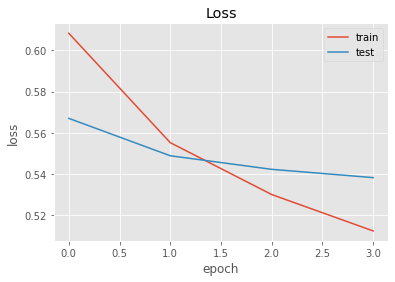

In [110]:
# plot loss

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
#plt.show();
plt.savefig('imgs/LSTM1_loss', bbox_inches='tight')

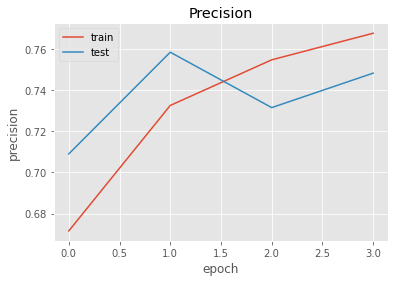

In [111]:
# plot precision

plt.title('Precision')
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
#plt.show();
plt.savefig('imgs/LSTM1_precision', bbox_inches='tight')

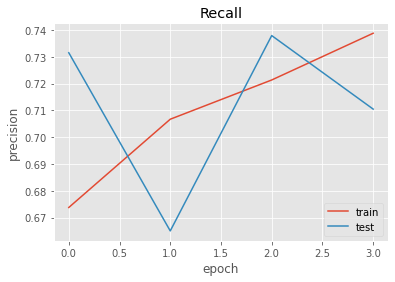

In [112]:
# plot recall

plt.title('Recall')
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
#plt.show();
#plt.savefig('imgs/LSTM1_precision', bbox_inches='tight')

In [62]:
# get cases of true positive, true negative, false positive, false negative

y_pred_LSTM1 = model.predict(X_test)
y_proba_LSTM1 = model.predict_proba(X_test)[:, 1]

KeyboardInterrupt: 

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_LSTM1))
print("Precision:", precision_score(y_test, y_pred_LSTM1))
print("Recall:", recall_score(y_test, y_pred_LSTM1))

#### LSTM with two layers and dropouts

In [125]:
model2 = Sequential()
model2.add(Embedding(10000, 100, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.4)) # start at 0
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)) # reduce recurrent_dropout later
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model2.add(Dense(1, activation='sigmoid'))
        
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), 
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

print(model2.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 200, 100)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 200, 100)          80400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 1,160,901
Trainable params: 1,160,901
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
# train on sample of 50k

history2 = model2.fit(sample_X_train_balanced, sample_y_train_balanced, 
                    epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/4
625/625 [==============================] - 245s 381ms/step - loss: 0.6363 - accuracy: 0.6272 - precision: 0.6256 - recall: 0.6333 - val_loss: 0.5738 - val_accuracy: 0.7041 - val_precision: 0.7591 - val_recall: 0.5969
Epoch 2/4
625/625 [==============================] - 236s 377ms/step - loss: 0.5572 - accuracy: 0.7262 - precision: 0.7391 - recall: 0.6949 - val_loss: 0.5472 - val_accuracy: 0.7285 - val_precision: 0.7367 - val_recall: 0.7103
Epoch 3/4
625/625 [==============================] - 235s 376ms/step - loss: 0.5289 - accuracy: 0.7449 - precision: 0.7602 - recall: 0.7213 - val_loss: 0.5472 - val_accuracy: 0.7301 - val_precision: 0.7412 - val_recall: 0.7060
Epoch 4/4
625/625 [==============================] - 235s 376ms/step - loss: 0.5111 - accuracy: 0.7576 - precision: 0.7700 - recall: 0.7438 - val_loss: 0.5424 - val_accuracy: 0.7347 - val_precision: 0.7443 - val_recall: 0.7141


In [126]:
# make sure to reinstantiate model

history2 = model2.fit(X_train_balanced, y_train_balanced, 
                    epochs=3, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
  47/6824 [..............................] - ETA: 52:11 - loss: 0.6931 - accuracy: 0.4897 - precision: 0.4982 - recall: 0.6254

KeyboardInterrupt: 

In [ ]:
# save model
model2.save('LSTM2.h5')

In [ ]:
# save history

hist2_df = pd.DataFrame(history2.history)

hist2 = 'history2.csv'
with open(hist2, mode='w') as f:
    hist2_df.to_csv(f)

In [83]:
## evaluate model

scores2 = model2.evaluate(X_test, y_test)

  606/53972 [..............................] - ETA: 51:27 - loss: 0.5387 - accuracy: 0.7502 - precision: 0.1034 - recall: 0.7120

KeyboardInterrupt: 

In [ ]:
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}\n  Precision: {:0.4}\n  Recall: {:0.4f}'.format(scores2[0],scores2[1], scores2[2], scores2[3]))


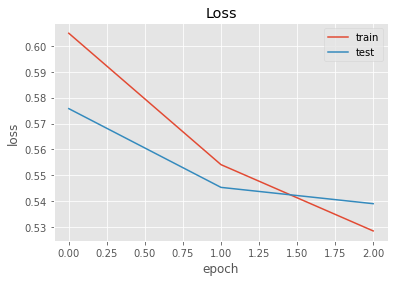

In [69]:
# plot loss

plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();
#plt.show();
#plt.savefig('imgs/LSTM2_loss', bbox_inches='tight')

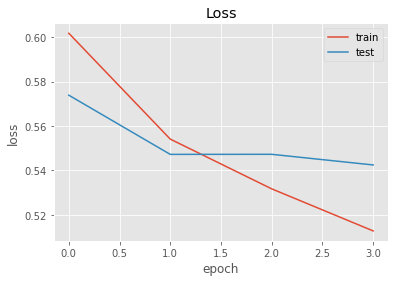

In [74]:
# plot loss

plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();
#plt.show();
#plt.savefig('imgs/LSTM2_loss', bbox_inches='tight')

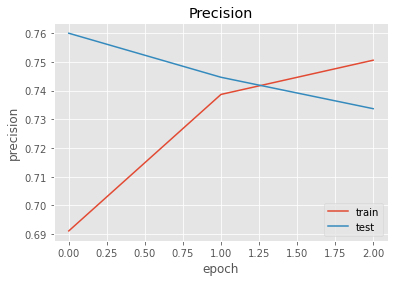

In [70]:
# plot precision

plt.title('Precision')
plt.plot(history2.history['precision'], label='train')
plt.plot(history2.history['val_precision'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();
#plt.show();
#plt.savefig('imgs/LSTM2_precision', bbox_inches='tight')

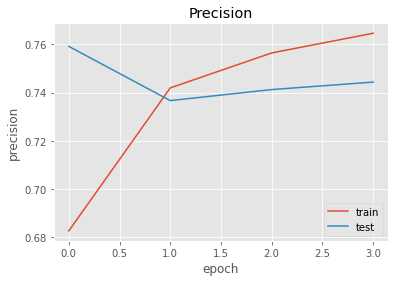

In [75]:
# plot precision

plt.title('Precision')
plt.plot(history2.history['precision'], label='train')
plt.plot(history2.history['val_precision'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();
#plt.show();
#plt.savefig('imgs/LSTM2_precision', bbox_inches='tight')

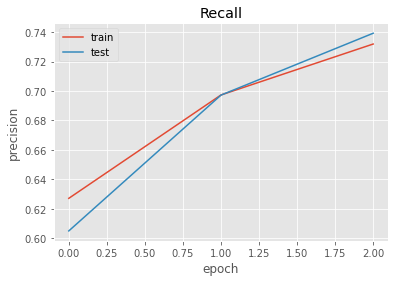

In [71]:
# plot recall

plt.title('Recall')
plt.plot(history2.history['recall'], label='train')
plt.plot(history2.history['val_recall'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();
#plt.show();
#plt.savefig('imgs/LSTM2_precision', bbox_inches='tight')

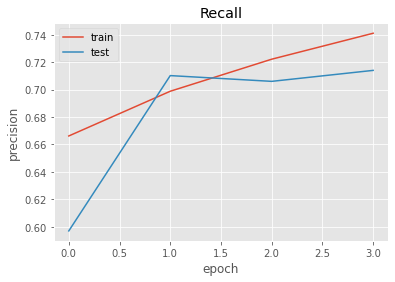

In [76]:
# plot recall

plt.title('Recall')
plt.plot(history2.history['recall'], label='train')
plt.plot(history2.history['val_recall'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();
#plt.show();
#plt.savefig('imgs/LSTM2_precision', bbox_inches='tight')

#### Bidirectional LSTM layer

In [99]:
# bidirectional LSTM layer

model3 = Sequential()
model3.add(Embedding(10000, 100, input_length=X.shape[1]))
model3.add(SpatialDropout1D(0.4)) # start at 0
model3.add(Bidirectional(LSTM(50))) # bidirectional layer
#model.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), 
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

print(model3.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 200, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 1,060,501
Trainable params: 1,060,501
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
# train on sample of 50k

history_sample_3 = model3.fit(sample_X_train_balanced, sample_y_train_balanced, 
                    epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
625/625 [==============================] - 87s 131ms/step - loss: 0.6537 - accuracy: 0.6410 - precision: 0.7230 - recall: 0.4575 - val_loss: 0.5753 - val_accuracy: 0.7053 - val_precision: 0.7384 - val_recall: 0.6348
Epoch 2/5
625/625 [==============================] - 70s 112ms/step - loss: 0.5672 - accuracy: 0.7199 - precision: 0.7302 - recall: 0.6935 - val_loss: 0.5516 - val_accuracy: 0.7230 - val_precision: 0.7467 - val_recall: 0.6740
Epoch 3/5
625/625 [==============================] - 67s 108ms/step - loss: 0.5352 - accuracy: 0.7430 - precision: 0.7583 - recall: 0.7158 - val_loss: 0.5410 - val_accuracy: 0.7333 - val_precision: 0.7354 - val_recall: 0.7279
Epoch 4/5
625/625 [==============================] - 69s 110ms/step - loss: 0.5096 - accuracy: 0.7602 - precision: 0.7743 - recall: 0.7373 - val_loss: 0.5396 - val_accuracy: 0.7381 - val_precision: 0.7488 - val_recall: 0.7157
Epoch 5/5
625/625 [==============================] - 69s 110ms/step - loss: 0.4925 - accuracy: 0

In [100]:
# make sure to reinstantiate model

history3 = model3.fit(X_train_balanced, y_train_balanced, 
                    epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/4
6824/6824 [==============================] - 905s 132ms/step - loss: 0.5734 - accuracy: 0.7035 - precision: 0.7262 - recall: 0.6496 - val_loss: 0.5228 - val_accuracy: 0.7441 - val_precision: 0.7306 - val_recall: 0.7738
Epoch 2/4
6824/6824 [==============================] - 880s 129ms/step - loss: 0.5175 - accuracy: 0.7477 - precision: 0.7536 - recall: 0.7372 - val_loss: 0.5163 - val_accuracy: 0.7458 - val_precision: 0.7388 - val_recall: 0.7609
Epoch 3/4
6824/6824 [==============================] - 870s 128ms/step - loss: 0.5075 - accuracy: 0.7533 - precision: 0.7527 - recall: 0.7544 - val_loss: 0.5127 - val_accuracy: 0.7488 - val_precision: 0.7509 - val_recall: 0.7449
Epoch 4/4
6824/6824 [==============================] - 873s 128ms/step - loss: 0.5031 - accuracy: 0.7558 - precision: 0.7561 - recall: 0.7551 - val_loss: 0.5146 - val_accuracy: 0.7490 - val_precision: 0.7347 - val_recall: 0.7797


In [107]:
# save model
model3.save('BiLSTM.h5')

In [124]:
# save history

hist3_df = pd.DataFrame(history3.history)

hist3 = 'history3.csv'
with open(hist3, mode='w') as f:
    hist3_df.to_csv(f)

In [105]:
# evalute model

scores3 = model3.evaluate(X_test, y_test)

53972/53972 [==============================] - 1112s 21ms/step - loss: 0.5525 - accuracy: 0.7223 - precision: 0.1015 - recall: 0.7720


In [106]:
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}\n  Precision: {:0.4}\n  Recall: {:0.4f}'.format(scores3[0],scores3[1], scores3[2], scores3[3]))

Test set
  Loss: 0.5525
  Accuracy: 0.7223
  Precision: 0.1015
  Recall: 0.7720


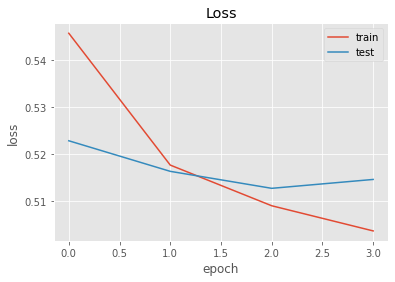

In [102]:
# plot loss

plt.title('Loss')
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
#plt.show();
#plt.savefig('imgs/BiLSTM_loss', bbox_inches='tight')

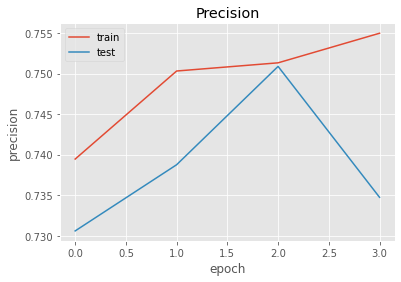

In [103]:
# plot precision

plt.title('Precision')
plt.plot(history3.history['precision'], label='train')
plt.plot(history3.history['val_precision'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
#plt.show();
#plt.savefig('imgs/BiLSTM_precision', bbox_inches='tight')

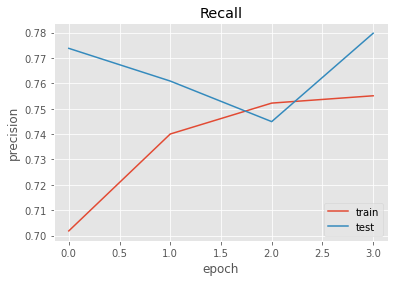

In [104]:
# plot recall

plt.title('Recall')
plt.plot(history3.history['recall'], label='train')
plt.plot(history3.history['val_recall'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
#plt.show();
#plt.savefig('imgs/BiLSTM_precision', bbox_inches='tight')

In [ ]:
# confusion matrix

confusion_matrix(y_test, y_pred)
# true positive, false negative
# false positive, true negative

In [ ]:
## to recreate these models using classes:

